API REQUESTS AND JSON READ FUNCTIONS
-Inputs = Coins, Timeframe

In [ ]:
# # Imports
# import datetime as dt
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# import cupy as cp
# import dask.dataframe as dd
# import My_API_wraps
# import My_feature_extraction_wraps
# import my_feature_selection_wraps
# from dask.distributed import Client, LocalCluster
# import xgboost
# from sklearn.metrics import r2_score
# import pandas as pd
# from xgboost import dask as dxgb
# from dask_ml.model_selection import train_test_split
# from dask_ml.model_selection import ShuffleSplit
# from dask_ml.model_selection import KFold
# import tqdm
# import os
# import warnings


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import dask.dataframe as dd
import My_API_Wraps
import My_FE_Wraps
import My_FS_Wraps
from dask.distributed import Client, LocalCluster
import xgboost
from sklearn.metrics import r2_score
import pandas as pd
import datetime as dt
import numpy as np
from xgboost import dask as dxgb
import os
import cupy as cp

In [ ]:
# # CPU Cluster
# cluster = LocalCluster(
#             n_workers=4,
#             threads_per_worker=5,
#             processes=True,
#             # memory_limit='12GB',
#             dashboard_address=':8787',
#             resources = {'GPU':1}
#         )

In [ ]:
# Configure CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)

cluster = LocalCluster(
    n_workers=1,              # Single worker for GPU
    processes=False,          # Thread-based
    threads_per_worker=20,    # Maximum threads for i7-13700H
    memory_limit='22GB',      # 75% of system RAM
    dashboard_address=':8788',
    resources={'GPU': 1}
)

In [3]:
client = Client(cluster)
periods= 1
timeframe= 3
top_coins= 2
api_key= "CG-r57ENE22zzPUiLmjnyFK7YHw"
headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": api_key
    }
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.220.10.17:8788/status,
Dashboard: http://10.220.10.17:8788/status,Workers: 1
Total threads: 20,Total memory: 20.49 GiB
Status: running,Using processes: False
Comm: inproc://10.220.10.17/15664/1,Workers: 1
Dashboard: http://10.220.10.17:8788/status,Total threads: 20
Started: Just now,Total memory: 20.49 GiB
Comm: inproc://10.220.10.17/15664/4,Total threads: 20
Dashboard: http://10.220.10.17:65361/status,Memory: 20.49 GiB
Nanny: None,


In [ ]:
# client.close()
# cluster.close()

In [ ]:
# df_pandas= My_API_Wraps.CoinGecko_HSPD_Pandas(timeframe, top_coins, periods, api_key)
# EF_pandas= My_FE_Wraps.EF_Pandas_MultiprocessingDistributor(df_pandas, ParameterComplexity=0)
# SF_pandas= My_FS_Wraps.SF_Pandas_Simple(EF_pandas)
# df_pandas= My_API_Wraps.CoinGecko_HSPD_Pandas(timeframe, top_coins, periods, api_key)
# EF_pandas2= My_FE_Wraps.EF_Pandas_DaskDistributor(df_pandas, cluster.scheduler_address, ParameterComplexity=0)
# SF_pandas= My_FS_Wraps.SF_Pandas_Simple(EF_pandas2)

In [21]:
raw_data= client.submit(My_API_Wraps.CoinGecko_HSPD_Dask, timeframe=timeframe, top_coins=top_coins, periods=periods, api_key=api_key, splits=timeframe*3)
ef= client.submit(My_FE_Wraps.EF_Dask, raw_data, ParameterComplexity=1, splits=1)
y = client.persist(ef.result()['y_future'].dropna().repartition(npartitions=10))
# extracted_features= client.persist(ef.result())
sf= client.submit(My_FS_Wraps.SF_Dask_v1, ef, p_value=0.05)
X= client.persist(sf.result().repartition(npartitions=10))

In [ ]:
X_train= X.partitions[0:7].persist()
y_train= y.partitions[0:7].persist()
X_test= X.partitions[7:9].persist()
y_test= y.partitions[7:9].persist()
dtrain = dxgb.DaskDMatrix(client, X_train, y_train)

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [ ]:
import optuna
# # 1. Prepare data
def objective(trial):
    params = {
        # Core Parameters
        "verbosity": 0,
        "tree_method": "hist",
        "eval_metric": 'mae',
        # Essential Parameters
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    }
    
    try:
        output = dxgb.train(
            client,
            params,
            dtrain,
            num_boost_round=20,
            evals=[(dtrain, "train")]
        )
        return output["history"]["train"]["mae"][-1]
    except Exception as e:
        print(f"Error in training: {str(e)}")
        return float('inf')

# Create and run study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, n_jobs=-1, show_progress_bar=True)


[I 2025-02-09 16:21:31,058] A new study created in memory with name: no-name-b2b5d1ac-5781-484f-a4e2-2ba43fab832f


  0%|          | 0/20 [00:00<?, ?it/s]

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially su

[I 2025-02-09 16:21:31,803] Trial 0 finished with value: 48.89361945950255 and parameters: {'lambda': 5.649524945766683, 'alpha': 2.054851467815057, 'colsample_bytree': 0.88576930086535, 'max_depth': 7, 'min_child_weight': 36.64242304845732, 'learning_rate': 0.00428637197983366, 'gamma': 0.5914890233866187}. Best is trial 0 with value: 48.89361945950255.
[I 2025-02-09 16:21:33,274] Trial 1 finished with value: 48.89361945950255 and parameters: {'lambda': 0.11908645003009811, 'alpha': 71.96418968433095, 'colsample_bytree': 0.3362327832183315, 'max_depth': 4, 'min_child_weight': 35.56830687998333, 'learning_rate': 2.799298351691444e-08, 'gamma': 0.006218749354019758}. Best is trial 0 with value: 48.89361945950255.
[I 2025-02-09 16:21:35,099] Trial 2 finished with value: 48.743188974808675 and parameters: {'lambda': 77.3417461055596, 'alpha': 2.207701173030209e-08, 'colsample_bytree': 0.5020049802423473, 'max_depth': 8, 'min_child_weight': 0.0006301045048771859, 'learning_rate': 0.0006391

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


Standard_Dev: 15.825819793964417
Best parameters: {'lambda': 0.12113151790803549, 'alpha': 8.314720704300028, 'colsample_bytree': 0.6674341888750475, 'max_depth': 7, 'min_child_weight': 0.0022086449464947997, 'learning_rate': 0.05318763641868539, 'gamma': 0.002408639781326289}
Best RMSE: 17.556680484693878
R2 Score: -5.914325046800371
score/std: 1.109369417399127


<Axes: xlabel='datetime'>

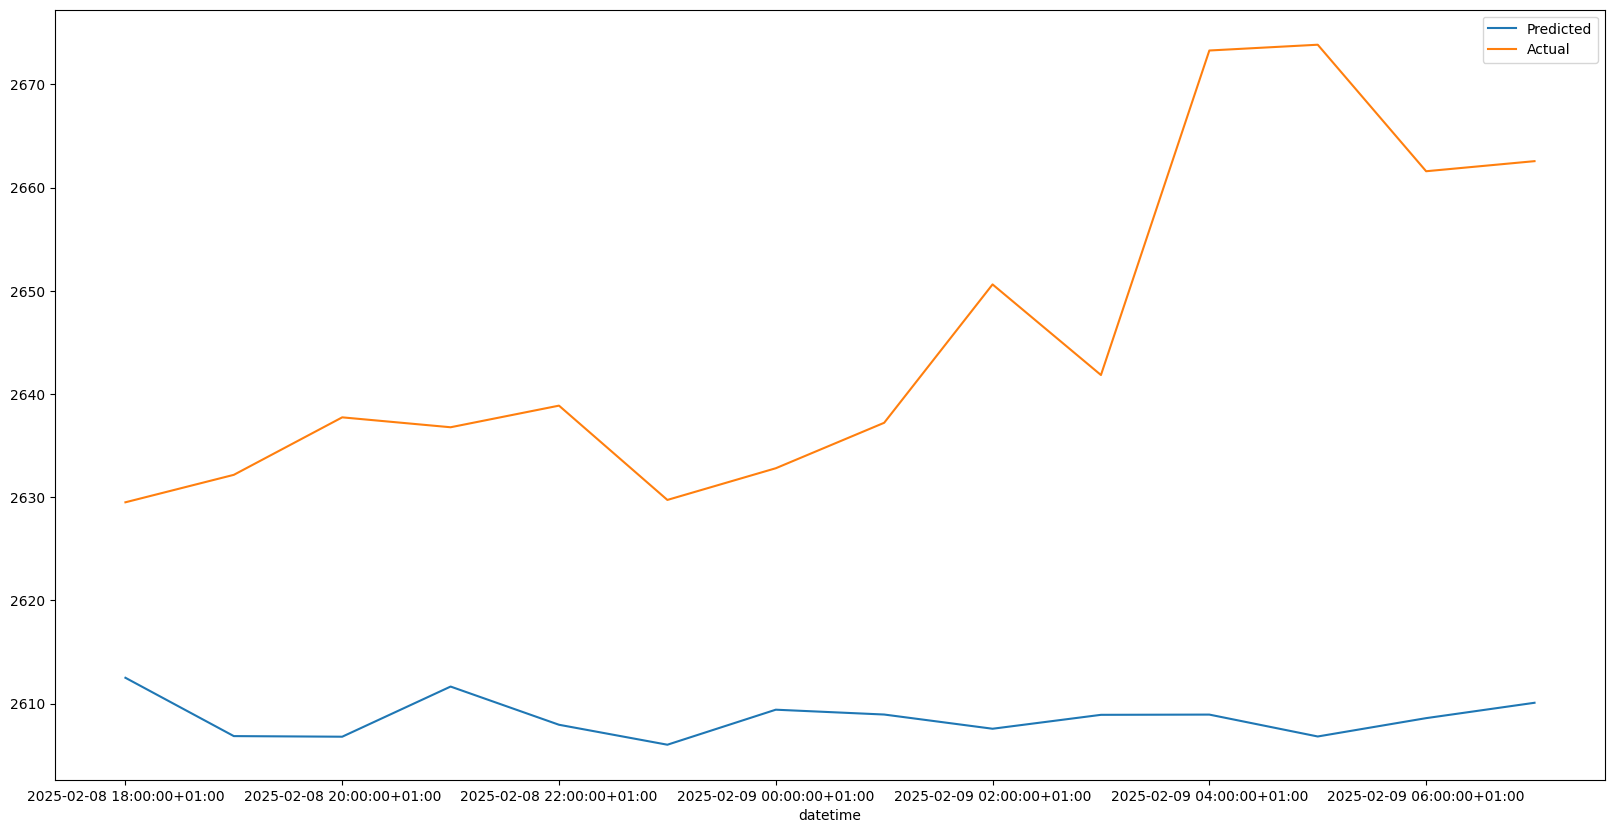

In [45]:
final_model= dxgb.train(client, study.best_params, dtrain, num_boost_round=300, evals=[(dtrain, "train")])
dtest = dd.from_pandas(X_test.compute())
# dxgb.DaskDMatrix(client, X_test, y_test)  # Ensure the test data has the same features as the training data
predictions = dxgb.predict(client, final_model, dtest)
r2 = r2_score(y_test.compute(), predictions)
std = y_test.std().compute()
score = study.best_value
Thresh_var = score/std 
print('Standard_Dev: '+ f'{std}')
print(f"Best parameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")
print(f"R2 Score: {r2}")
print(f'score/std: {Thresh_var}')
viz= pd.DataFrame(columns=["Predicted", "Actual"], index=y_test.index.compute())
viz['Predicted'] = predictions
viz['Actual'] = y_test.compute().values
viz.plot(figsize=(20,10))

In [ ]:
# X_values = X_test.to_dask_array(lengths=True).persist()
# y_values = y_test.to_dask_array(lengths=True).persist()
# # Create DaskMatrix with numpy arrays
# dtest = dxgb.DaskQuantileDMatrix(client, X_values, y_values)
# final_model= dxgb.train(client, study.best_params, dtrain, num_boost_round=100, evals=[(dtrain, "train")])
# predictions = dxgb.predict(client, final_model['booster'], X_values).compute()
# r2 = r2_score(y_values.compute(), predictions)
# std = y_test.std().compute()
# score = study.best_value
# Thresh_var = score/std 
# print('Standard_Dev: '+ f'{std}')
# print(f"Best parameters: {study.best_params}")
# print(f"Best RMSE: {study.best_value}")
# print(f"R2 Score: {r2}")
# print(f'score/std: {Thresh_var}')
# viz= pd.DataFrame(columns=["Predicted", "Actual"], index=y_test.index.compute())
# viz['Predicted'] = predictions
# viz['Actual'] = y_test.compute().values
# viz.plot(figsize=(20,10))
# # Trial 18 finished with value: 1.893057914402174 and parameters: {'lambda': 1.5466954034804144e-07, 'alpha': 86.9687234842023, 'colsample_bytree': 0.819553438689065, 'max_depth': 4, 'min_child_weight': 0.002451210332961274, 'learning_rate': 0.46436439361631066, 'gamma': 5.4389970694464654e-08}. Best is trial 18 with value: 1.893057914402174.


In [ ]:
# estimated_performance = r2_score(y_eval.compute(), predictions)
# predictions = pd.DataFrame(predictions, columns= ['predicted_testtrain'], index= X_eval.index.compute().shift(freq=f'{periods}min'))
# predictions['realised']= y_eval.compute().values
# # predictions= predictions* 100
# score = study.best_value
# std = y_eval.std().compute()
# print('RMSE: '+ f'{score}')
# print('Standard_Dev: '+ f'{std}')
# print(f'R2: {estimated_performance}')
# feature_imp= pd.DataFrame.from_dict(booster.get_fscore(), orient='index', columns=['feature_importance']).sort_values(by='feature_importance', ascending=False)
# # feature_imp = pd.DataFrame(data = chosen_model.feature_importances_, index= chosen_model.feature_names_in_, columns=['f_imp']).sort_values(ascending=False, by='f_imp')
# Thresh_var = score/std 
# print(f'score/std: {Thresh_var}')
# display(feature_imp)

In [ ]:
# GPU Accelerated XGBoost Using Random Gridsearch for Hyperparameter Tuning 
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model_parameters={
'num_parallel_tree': [1,3,5,10,20],
'learning_rate': [0.01,0.01,0.05,0.1,0.5,1],
'max_depth': [3,6,12,24,48],
'gamma':[0,0.01,0.05,0.1,0.5,1,5,25],
'min_child_weight':[0.5,1,3,5],
'subsample':[1,0.05, 0.1,0.25,0.5],
'sampling_method':['uniform', 'gradient_based'],
'colsample_bytree':[1, 0.1, 0.5, 1],
'grow_policy':['depthwise', 'lossguide']
}
basemodel= xgb.XGBRegressor(eval_metric='mae', early_stopping_rounds=25, 
                        device= 'cuda',tree_method='hist', n_jobs=1, verbose=0)
rgs= RandomizedSearchCV(estimator=basemodel, verbose= 25, n_jobs=1,
                        cv=tscv,param_distributions=model_parameters, n_iter=20, refit=True).fit(X_train, y_train, eval_set=[X_test, y_test])

In [ ]:
# Model Results
chosen_model= xgb.XGBRegressor(eval_metric='mae', early_stopping_rounds= 25, device= 'cuda',tree_method='hist',**rgs.best_params_, n_jobs=1)
chosen_model.fit(X_train_cp, y_train_cp, eval_set= [(X_test_cp, y_test_cp)])
preds=chosen_model.predict(X_test)
estimated_performance = r2_score(y_test, preds)
predictions = pd.DataFrame(preds, columns= ['predicted_testtrain'], index= X_test.index.shift(freq=f'{periods}min'))
predictions['realised']= y_test.values
predictions= predictions* 100
score = chosen_model.best_score*100
std = features['y_future'].std()*100
print('Mean_absolute error: '+ f'{score}')
print('Standard_Dev: '+ f'{std}')
print(f'R2: {estimated_performance}')
feature_imp = pd.DataFrame(data = chosen_model.feature_importances_, index= chosen_model.feature_names_in_, columns=['f_imp']).sort_values(ascending=False, by='f_imp')
Thresh_var = score/std 
print(f'score/std: {Thresh_var}')
display(feature_imp)

In [ ]:
# # final model for deployment and plot of predicted, realised, and untested future predictions
final_model = xgb.XGBRegressor(device= 'cuda',tree_method='hist',**rgs.best_params_)
final_model.fit(X, y)
deployment_preds= features.drop('y_future', axis=1)[X.columns].tail(shift)
dep_preds=final_model.predict(deployment_preds)
dep_preds= pd.Series(dep_preds, index=deployment_preds.index.shift(freq=freq), name='untested_predictions')
predictions.join(dep_preds, how='outer').plot()

In [ ]:
# # PancakeSwap API
# import requests
# import json

# # Replace with your PancakeSwap API endpoint and API key
API_ENDPOINT = 'https://api.pancakeswap.info/api/v2/orders'
API_KEY = 'your_api_key_here'

def place_order(order_type, amount, leverage, price=None):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {API_KEY}'
    }
    order_data = {
        'type': order_type,  # 'buy' or 'sell'
        'amount': amount,    # Amount of ETH to trade
        'leverage': leverage # Leverage to use
    }
    if price:
        order_data['price'] = price  # Set price for limit orders
    else:
        order_data['price'] = 'market'  # Set price to market for market orders

    response = requests.post(API_ENDPOINT, headers=headers, data=json.dumps(order_data))
    if response.status_code == 200:
        print(f"Order placed successfully: {response.json()}")
    else:
        print(f"Failed to place order: {response.status_code}, {response.text}")

# Example usage
place_order('buy', 0.1, 10)  # Place a market buy order for 0.1 ETH with 10x leverage
place_order('sell', 0.1, 10, 3600.10)  # Place a limit sell order for 0.1 ETH at $3600.10 with 10x leverage
# In this example, if you don't provide a price, the order will be placed at the market price. If you provide a price, it will be treated as a limit order. This way, you can easily switch between market and limit orders based on your trading strategy. Happy trading!


def execute_trade(prediction): 
    if prediction >= 0.02: 
        place_order('buy', 0.1, 10)  # Place a buy order for 0.1 ETH at $3600.10 with 10x leverage
    elif prediction <= -0.02:
        place_order('sell', 0.1, 10)



In [ ]:
# # Main trading loop
# while True:
#     market_data = fetch_market_data()
#     prediction = make_prediction(market_data)
#     execute_trade(prediction)
#     # Sleep for 30 minutes before making the next prediction
#     time.sleep(1800)
